# Lesson 3: Email Assistant with Semantic Memory

We previously built an email assistant that:
- Classifies incoming messages (respond, ignore, notify)
- Drafts responses
- Schedules meetings

Now, we'll add memory.
We'll give the assistant the ability to remember details from previous emails.

## Repeat setup email assistant agent from previous lesson


In [4]:
import os
from dotenv import load_dotenv
_ = load_dotenv()

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google Gemini API key: ")


In [5]:
from prompts import triage_system_prompt, triage_user_prompt

profile = {
    "name": "John",
    "full_name": "John Doe",
    "user_profile_background": "Senior software engineer leading a team of 5 developers",
}

prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use these tools when appropriate to help manage John's tasks efficiently."
}

email = {
    "from": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "body": """
Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [6]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    max_tokens=None,
    model="gemini-2.0-flash-exp",
    temperature=1,
    top_k=1,
    top_p=0.9
)


In [7]:
class Router(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

llm_router = llm.with_structured_output(Router)

In [8]:
from langchain_core.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"

@tool
def schedule_meeting(
    attendees: list[str], 
    subject: str, 
    duration_minutes: int, 
    preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"


## Define tools for managing memory

In [35]:
from langgraph.store.memory import InMemoryStore

from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

store = InMemoryStore(
    index={"embed": embeddings}#"google:models/embedding-005"}
)

In [36]:
from langmem import create_manage_memory_tool, create_search_memory_tool

manage_memory_tool = create_manage_memory_tool(
    namespace=(
        "email_assistant", 
        "{langgraph_user_id}",
        "collection"
    )
)
search_memory_tool = create_search_memory_tool(
    namespace=(
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    )
)


In [37]:
print(manage_memory_tool.name)
print(manage_memory_tool.description)
print(manage_memory_tool.args)


manage_memory
Create, update, or delete persistent MEMORIES to persist across conversations.
Include the MEMORY ID when updating or deleting a MEMORY. Omit when creating a new MEMORY - it will be created for you.
Proactively call this tool when you:

1. Identify a new USER preference.
2. Receive an explicit USER request to remember something or otherwise alter your behavior.
3. Are working and want to record important context.
4. Identify that an existing MEMORY is incorrect or outdated.
{'content': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'default': None, 'title': 'Content'}, 'action': {'default': 'create', 'enum': ['create', 'update', 'delete'], 'title': 'Action', 'type': 'string'}, 'id': {'anyOf': [{'format': 'uuid', 'type': 'string'}, {'type': 'null'}], 'default': None, 'title': 'Id'}}


In [38]:
print(search_memory_tool.name)
print(search_memory_tool.description)
print(search_memory_tool.args)

search_memory
Search your long-term memories for information relevant to your current context.
{'query': {'title': 'Query', 'type': 'string'}, 'limit': {'default': 10, 'title': 'Limit', 'type': 'integer'}, 'offset': {'default': 0, 'title': 'Offset', 'type': 'integer'}, 'filter': {'anyOf': [{'type': 'object'}, {'type': 'null'}], 'default': None, 'title': 'Filter'}}


## Modify system prompt to add 2 memory tools

In [52]:
agent_system_prompt_memory = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
4. manage_memory - Store any relevant information about written emails, contacts, actions, discussion, etc. in memory for future reference
5. search_memory - Search for any relevant information that may have been stored in memory
</ Tools >

< Instructions >
{instructions}
</ Instructions >
"""

def create_prompt(state):
    return [
        {
            "role": "system", 
            "content": agent_system_prompt_memory.format(
                instructions=prompt_instructions["agent_instructions"], 
                **profile
            )
        }
    ] + state['messages']

In [53]:
from langgraph.prebuilt import create_react_agent

tools= [
    write_email, 
    schedule_meeting,
    check_calendar_availability,
    manage_memory_tool,
    search_memory_tool
]
response_agent = create_react_agent(
    # Gemini foundation model
    llm,
    tools=tools,
    prompt=create_prompt,
    # Use this to ensure the store is passed to the agent 
    store=store
)

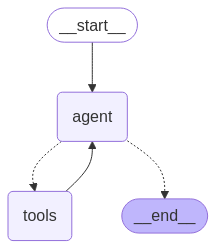

In [54]:
from IPython.display import Image, display

# Show the agent
display(Image(response_agent.get_graph(xray=True).draw_mermaid_png()))

In [55]:
config = {"configurable": {"langgraph_user_id": "lance"}}

response = response_agent.invoke(
    {"messages": [{"role": "user", "content": "Jim is my friend"}]},
    config=config
)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Jim is my friend
================================== Ai Message ==================================
Tool Calls:
  manage_memory (819c4772-2934-4e8c-a269-981506b42c7b)
 Call ID: 819c4772-2934-4e8c-a269-981506b42c7b
  Args:
    content: Jim is John's friend.
    action: create
================================= Tool Message =================================
Name: manage_memory

created memory 0a310c6b-e771-4c88-8f5b-c88c011c262d
================================== Ai Message ==================================

Okay, I've saved that Jim is your friend. Is there anything else I can help you with today?


In [56]:
response = response_agent.invoke(
    {"messages": [{"role": "user", "content": "who is jim?"}]},
    config=config
)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

who is jim?
================================== Ai Message ==================================
Tool Calls:
  search_memory (18b80415-2163-4bdf-a701-3855a48b5250)
 Call ID: 18b80415-2163-4bdf-a701-3855a48b5250
  Args:
    query: jim
================================= Tool Message =================================
Name: search_memory

[{"namespace": ["email_assistant", "lance", "collection"], "key": "67980148-1f1c-4a12-af2b-f3eac8b3cfb5", "value": {"content": "Jim is John's friend."}, "created_at": "2025-03-24T06:41:09.991822+00:00", "updated_at": "2025-03-24T06:41:09.991827+00:00", "score": 0.6841846552394559}, {"namespace": ["email_assistant", "lance", "collection"], "key": "0a310c6b-e771-4c88-8f5b-c88c011c262d", "value": {"content": "Jim is John's friend."}, "created_at": "2025-03-24T06:58:22.027525+00:00", "updated_at": "2025-03-24T06:58:22.027540+00:00", "score": 0.6841846552394559}]
=====================

In [57]:
print(store.list_namespaces())
print(store.search(('email_assistant', 'lance', 'collection')))
print(store.search(('email_assistant', 'lance', 'collection'), query="jim"))

[('email_assistant', 'lance', 'collection')]
[Item(namespace=['email_assistant', 'lance', 'collection'], key='67980148-1f1c-4a12-af2b-f3eac8b3cfb5', value={'content': "Jim is John's friend."}, created_at='2025-03-24T06:41:09.991822+00:00', updated_at='2025-03-24T06:41:09.991827+00:00', score=None), Item(namespace=['email_assistant', 'lance', 'collection'], key='0a310c6b-e771-4c88-8f5b-c88c011c262d', value={'content': "Jim is John's friend."}, created_at='2025-03-24T06:58:22.027525+00:00', updated_at='2025-03-24T06:58:22.027540+00:00', score=None)]
[Item(namespace=['email_assistant', 'lance', 'collection'], key='67980148-1f1c-4a12-af2b-f3eac8b3cfb5', value={'content': "Jim is John's friend."}, created_at='2025-03-24T06:41:09.991822+00:00', updated_at='2025-03-24T06:41:09.991827+00:00', score=0.6841846552394559), Item(namespace=['email_assistant', 'lance', 'collection'], key='0a310c6b-e771-4c88-8f5b-c88c011c262d', value={'content': "Jim is John's friend."}, created_at='2025-03-24T06:58:2

## Create the rest of the agent

In [58]:
from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

In [59]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal

def triage_router(state: State) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    system_prompt = triage_system_prompt.format(
        full_name=profile["full_name"],
        name=profile["name"],
        user_profile_background=profile["user_profile_background"],
        triage_no=prompt_instructions["triage_rules"]["ignore"],
        triage_notify=prompt_instructions["triage_rules"]["notify"],
        triage_email=prompt_instructions["triage_rules"]["respond"],
        examples=None
    )
    user_prompt = triage_user_prompt.format(
        author=author, 
        to=to, 
        subject=subject, 
        email_thread=email_thread
    )
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

In [60]:
email_agent = StateGraph(State)
email_agent = email_agent.add_node(triage_router)
email_agent = email_agent.add_node("response_agent", response_agent)
email_agent = email_agent.add_edge(START, "triage_router")
# Use this to ensure the store is passed to the agent in compile
email_agent = email_agent.compile(store=store) 

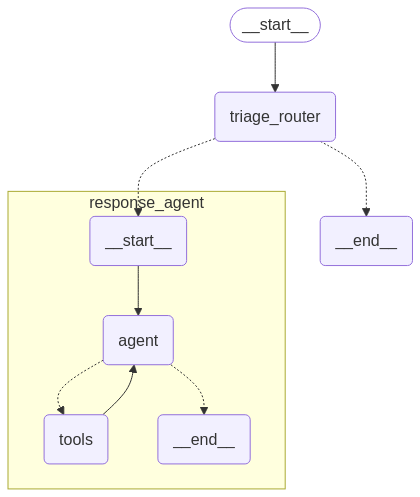

In [61]:
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

## Invoke

In [ ]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

response = email_agent.invoke(
    {"email_input": email_input},
    config=config
)

for m in response["messages"]:
    m.pretty_print()

📧 Classification: RESPOND - This email requires a response
================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}
================================== Ai Message ==================================

Okay, I'll respond to Alice's email. Here's the plan:

1.  **Write the email** to Alice, acknowledging her question and offering to investigate the missing endpoints in the API documentation.
2.  **Store a memory** that I responded to Alice's email regarding the API documentat

### Try a follow-up email

In [63]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Follow up",
    "email_thread": """Hi John,

Any update on my previous ask?""",
}

response = email_agent.invoke({"email_input": email_input}, config=config)

for m in response["messages"]:
    m.pretty_print()

📧 Classification: RESPOND - This email requires a response
================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Follow up', 'email_thread': 'Hi John,\n\nAny update on my previous ask?'}
================================== Ai Message ==================================
Tool Calls:
  write_email (8c12a300-694b-4ba7-9a7d-5f701d8951b3)
 Call ID: 8c12a300-694b-4ba7-9a7d-5f701d8951b3
  Args:
    to: Alice Smith <alice.smith@company.com>
    content: Hi Alice,

I'm looking into it and will get back to you soon.

Best,
John
    subject: Re: Follow up
================================= Tool Message =================================
Name: write_email

Email sent to Alice Smith <alice.smith@company.com> with subject 'Re: Follow up'
================================== Ai Message ==================================

OK. I've replied to Alice's email, 